# Building a Natural Language to SQL Agent Tutorial

## Setup
First, make sure you have all required packages installed:
```bash
pip install -r requirements.txt
```

And ensure you have your OpenAI API key in a `.env` file:
```
OPENAI_API_KEY=your-api-key-here
```

In [14]:
# Install required packages if needed
!pip install -r requirements.txt

  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl (11.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 2.0 MB/s eta 0:00:0000:0100:01
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.3 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346

In [21]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.chat_models import ChatOpenAI
from langchain.agents import create_sql_agent
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from dotenv import load_dotenv
import os

In [22]:
# Create the database explorer function
def explore_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    print("\n=== Database Explorer ===")
    
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    print("\nTables in database:")
    for table in tables:
        print(f"- {table[0]}")
        
        cursor.execute(f"PRAGMA table_info({table[0]})")
        columns = cursor.fetchall()
        print("  Columns:")
        for col in columns:
            print(f"    {col[1]} ({col[2]})")
            
        cursor.execute(f"SELECT COUNT(*) FROM {table[0]}")
        count = cursor.fetchone()[0]
        print(f"  Row count: {count}")
        
        cursor.execute(f"SELECT * FROM {table[0]} LIMIT 3")
        rows = cursor.fetchall()
        print("  Sample data:")
        for row in rows:
            print(f"    {row}")
        print()
    
    conn.close()

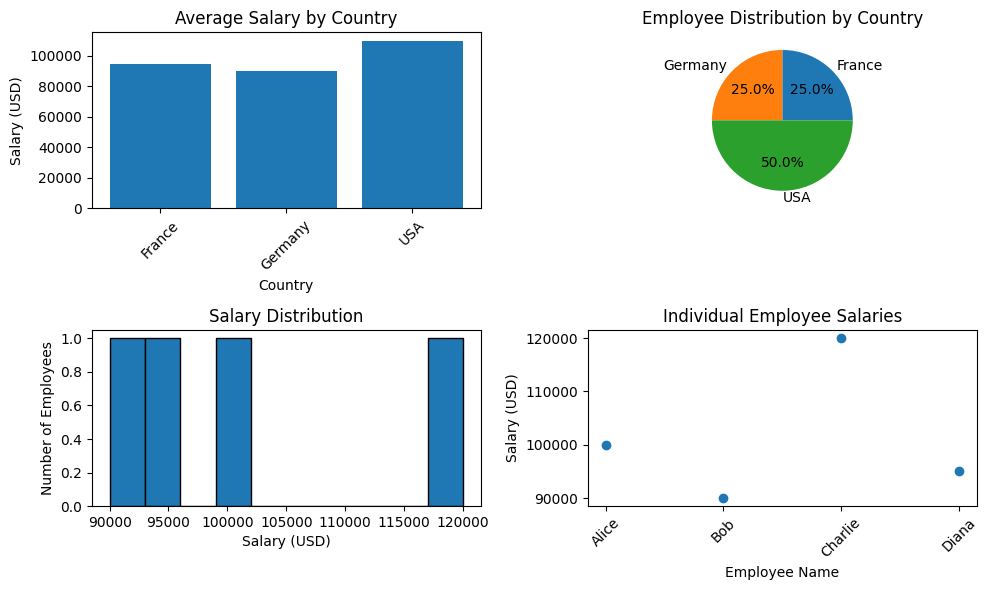


Summary Statistics:
count         4.000000
mean     101250.000000
std       13149.778198
min       90000.000000
25%       93750.000000
50%       97500.000000
75%      105000.000000
max      120000.000000
Name: salary, dtype: float64

Employee Details:
|    |   id | name    | country   |   salary |
|---:|-----:|:--------|:----------|---------:|
|  0 |    1 | Alice   | USA       |   100000 |
|  1 |    2 | Bob     | Germany   |    90000 |
|  2 |    3 | Charlie | USA       |   120000 |
|  3 |    4 | Diana   | France    |    95000 |


In [23]:
## Data Visualization

# Let's visualize our employee data using pandas and matplotlib to get better insights.
# Import visualization libraries
import pandas as pd
import matplotlib.pyplot as plt

def visualize_employee_data(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Create different visualizations
    
    # 1. Average Salary by Country
    plt.figure(figsize=(10, 6))
    df_salary = pd.read_sql_query(
        "SELECT country, AVG(salary) as avg_salary FROM employees GROUP BY country",
        conn
    )
    plt.subplot(2, 2, 1)
    plt.bar(df_salary['country'], df_salary['avg_salary'])
    plt.title("Average Salary by Country")
    plt.xlabel("Country")
    plt.ylabel("Salary (USD)")
    plt.xticks(rotation=45)
    
    # 2. Employee Distribution by Country
    plt.subplot(2, 2, 2)
    df_count = pd.read_sql_query(
        "SELECT country, COUNT(*) as employee_count FROM employees GROUP BY country",
        conn
    )
    plt.pie(df_count['employee_count'], labels=df_count['country'], autopct='%1.1f%%')
    plt.title("Employee Distribution by Country")
    
    # 3. Salary Distribution
    plt.subplot(2, 2, 3)
    df_all = pd.read_sql_query("SELECT * FROM employees", conn)
    plt.hist(df_all['salary'], bins=10, edgecolor='black')
    plt.title("Salary Distribution")
    plt.xlabel("Salary (USD)")
    plt.ylabel("Number of Employees")
    
    # 4. Individual Salaries
    plt.subplot(2, 2, 4)
    plt.scatter(df_all['name'], df_all['salary'])
    plt.title("Individual Employee Salaries")
    plt.xlabel("Employee Name")
    plt.ylabel("Salary (USD)")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(df_all['salary'].describe())
    
    # Print employee details in a nice table format
    print("\nEmployee Details:")
    print(df_all.to_markdown())
    
    conn.close()

# Run the visualization
visualize_employee_data(temp_db_file)


In [24]:
# Create the database and insert data
temp_db_file = "temp_langchain_employees.db"

# Create a new connection
conn_disk = sqlite3.connect(temp_db_file)
cur_disk = conn_disk.cursor()

# Drop and recreate the table
cur_disk.execute("DROP TABLE IF EXISTS employees")
cur_disk.execute("""
    CREATE TABLE employees (
        id INTEGER PRIMARY KEY,
        name TEXT,
        country TEXT,
        salary INTEGER
    )
""")

# Insert sample data
employees_data = [
    (1, 'Alice',   'USA',     100000),
    (2, 'Bob',     'Germany', 90000),
    (3, 'Charlie', 'USA',     120000),
    (4, 'Diana',   'France',  95000),
]
cur_disk.executemany("INSERT INTO employees VALUES (?, ?, ?, ?)", employees_data)
conn_disk.commit()
conn_disk.close()

print(f"Database created at: {os.path.abspath(temp_db_file)}")

Database created at: /Users/obamain/Code/2025/text2sql/temp_langchain_employees.db


In [25]:
# Now let's explore the database we just created
explore_db(temp_db_file)


=== Database Explorer ===

Tables in database:
- employees
  Columns:
    id (INTEGER)
    name (TEXT)
    country (TEXT)
    salary (INTEGER)
  Row count: 4
  Sample data:
    (1, 'Alice', 'USA', 100000)
    (2, 'Bob', 'Germany', 90000)
    (3, 'Charlie', 'USA', 120000)



In [26]:
# Create and run the AI agent
load_dotenv()

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
db = SQLDatabase.from_uri(f"sqlite:///{temp_db_file}")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

# Test the agent
result = agent.run("How many employees are there?")
print("\nAgent's response:")
print(result)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: employeesI should query the number of rows in the employees table to determine how many employees there are.
Action: sql_db_query
Action Input: SELECT COUNT(*) FROM employees[(4,)]There are 4 employees in the database.
Final Answer: There are 4 employees.

> Finished chain.

Agent's response:
There are 4 employees.


In [27]:
# Try another question
result = agent.run("Do we have Alice in the database?")
print("\nAgent's response:")
print(result)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: employeesI should query the employees table to see if Alice is in the database.
Action: sql_db_schema
Action Input: employees
CREATE TABLE employees (
	id INTEGER, 
	name TEXT, 
	country TEXT, 
	salary INTEGER, 
	PRIMARY KEY (id)
)

/*
3 rows from employees table:
id	name	country	salary
1	Alice	USA	100000
2	Bob	Germany	90000
3	Charlie	USA	120000
*/I can query the employees table for Alice.
Action: sql_db_query
Action Input: SELECT * FROM employees WHERE name = 'Alice'[(1, 'Alice', 'USA', 100000)]I found Alice in the database.
Final Answer: Yes, Alice is in the database with id 1, country USA, and salary 100000.

> Finished chain.

Agent's response:
Yes, Alice is in the database with id 1, country USA, and salary 100000.
